# Load dataset

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 60)
traffic = pd.read_csv("traffic_fines_1.csv", sep=';', low_memory=False)
display(traffic.head(3))
traffic.shape

,article,vehicleClass,amount,points,Case ID,Activity,Resource,lastSent,notificationType,dismissal,expense,Complete Timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,label
0,157.0,A,35.0,0.0,A100,Create Fine,561.0,missing,missing,NIL,0.0,2006-08-02 01:00:00,60,8,2,1,0.0,0.0,1,11246,deviant
1,157.0,A,35.0,0.0,A100,Send Fine,561.0,missing,missing,NIL,11.0,2006-12-12 01:00:00,60,12,1,1,190080.0,190080.0,2,12380,deviant
2,157.0,A,35.0,0.0,A100,Insert Fine Notification,561.0,P,P,NIL,11.0,2007-01-15 01:00:00,60,1,0,1,48960.0,239040.0,3,12202,deviant


(460556, 21)

In [2]:
import EventLog as el

In [3]:
log = el.EventLog(traffic, 'Case ID', 'Complete Timestamp')

Found False


/Users/florianlang/ProgrammingProjects/python/predictive-monitoring-evolution/EventLog.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  temp = pd.to_datetime(self.df[self.timestamp_column], infer_datetime_format=True,utc=True, errors='raise')


In [4]:
log.static_columns()

['article', 'vehicleClass', 'points', 'timesincemidnight', 'hour', 'label']

In [5]:
log.df.nunique()

article                   50
vehicleClass               4
amount                   204
points                     9
Case ID               129615
Activity                  10
Resource                 148
lastSent                   4
notificationType           3
dismissal                  8
expense                   84
Complete Timestamp      4903
timesincemidnight          1
month                     12
weekday                    7
hour                       1
timesincelastevent      1086
timesincecasestart      1360
event_nr                  20
open_cases             17274
label                      2
dtype: int64

# Preprocess and encode

In [6]:
from sklearn.preprocessing import OneHotEncoder
encoder = el.LogEncoder(transformers = [('static_drop', 'drop', []),
                                     ('static_keep', 'keep', ['amount', 'points']),
                                     ('static_onehot', el.WrapperEncoder(log.id_column,OneHotEncoder(sparse_output=False)), ['article', 'vehicleClass']),
                                     ('dynamic_drop', 'drop', []),
                                     ('dynamic_keep', 'keep', ['expense', 'timesincelastevent', 'timesincecasestart', 'timesincemidnight', 'event_nr', 'month', 'weekday', 'hour', 'open_cases']),
                                     ('dynamic_freq', el.FrequencyEncoder(log.id_column), ['Activity', 'Resource', 'lastSent','notificationType', 'dismissal']),
                                     ('timestamp', el.TimestampFeatures(log.id_column, ['event_order', 'time_from_start', 'remaining_time', 'elapsed_time_from_event']), [log.timestamp_column])])


encoder.check_unused(log)

['Case ID', 'label']

In [7]:
X = encoder.fit_transform(log)

Fitting static_drop
Fitting static_keep
Fitting static_onehot
Fitting dynamic_drop
Fitting dynamic_keep
Fitting dynamic_freq
Fitting timestamp
Transforming static_drop
Transforming static_keep
Transforming static_onehot
Transforming dynamic_drop
Transforming dynamic_keep
Transforming dynamic_freq
Transforming timestamp


In [8]:
X.shape

(460556, 242)

In [9]:
(X.isnull().sum() > 0).sum()

0

In [10]:
import datetime

for col in X.columns:
    # if isinstance(X[col].dtype, datetime.datetime):
    #     print(col)
    print(col, X[col].dtype)

amount float64
points float64
article_102.0 float64
article_115.0 float64
article_116.0 float64
article_122.0 float64
article_125.0 float64
article_126.0 float64
article_136.0 float64
article_141.0 float64
article_142.0 float64
article_143.0 float64
article_145.0 float64
article_146.0 float64
article_148.0 float64
article_149.0 float64
article_15.0 float64
article_152.0 float64
article_154.0 float64
article_155.0 float64
article_156.0 float64
article_157.0 float64
article_158.0 float64
article_167.0 float64
article_169.0 float64
article_170.0 float64
article_171.0 float64
article_172.0 float64
article_173.0 float64
article_180.0 float64
article_181.0 float64
article_188.0 float64
article_189.0 float64
article_190.0 float64
article_191.0 float64
article_192.0 float64
article_193.0 float64
article_20.0 float64
article_21.0 float64
article_213.0 float64
article_23.0 float64
article_29.0 float64
article_40.0 float64
article_401.0 float64
article_41.0 float64
article_43.0 float64
article_7.

# Descriptive analysis
We show some information concerning the distribution of the label (equally distributed), the categorical values and the events in each year (the number of events decreases with time and 2013 seems incomplete)

In [11]:
y = log.df['label']
y.value_counts()

label
deviant    239478
regular    221078
Name: count, dtype: int64

In [12]:
catcols = list(set(X.columns.values) - set(['amount', 'event_nr', 'expense', 'hour', 'month', 'open_cases', 'timesincecasestart', 'timesincelastevent', 'timesincemidnight', 'weekday']))

In [13]:
X.loc[:,catcols].max()

Resource_546.0           9.0
Resource_3.0             4.0
dismissal_NIL           20.0
dismissal_other          8.0
Resource_33.0            6.0
                        ... 
Activity_Create Fine     1.0
Resource_562.0           9.0
article_43.0             1.0
Resource_567.0           9.0
Resource_821.0           9.0
Length: 232, dtype: float64

In [14]:
log.df[log.timestamp_column].dt.year.value_counts()

Complete Timestamp
2000    49467
2006    46157
2005    43633
2001    41835
2009    37676
2002    36165
2007    35385
2008    34177
2011    31678
2004    30191
2003    29034
2010    27840
2012    14715
2013     2603
Name: count, dtype: int64

# Experiments

## RQ1: Does the dataset changes over time?
To answer this question, we split the dataset into a set of intervals (e.g. each 9 months) and test whether the distribution of values of categorical attributes between the different intervals is statistically significant using chi2

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
def draw_heatmap(data, vmax=None):
    s = len(data.columns)+1
    yticklabels=['[I'+str(i)+"] "+data.columns[i-1].left.strftime('%m-%Y') + " to " + data.columns[i-1].right.strftime('%m-%Y') for i in range(1,s)]
    xticklabels=['[I'+str(i)+']' for i in range(1,s)]
    fig, ax = plt.subplots()
    ax = sns.heatmap(data, yticklabels = yticklabels, xticklabels=xticklabels,vmax=vmax)
    ax.set_xlabel("")
    ax.set_ylabel("")    
    
    return ax

In [16]:
from splitters import TimeCaseSplit
from splitters import DriftStrategy, CombineStrategy, CummulativeStrategy, SamplingStrategy, NonCummulativeStrategy, BaselineStrategy
from contingency import compute_all_chi2

current_strategy = BaselineStrategy()

tcs = TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100)
tcs_splits = tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column], strategy=current_strategy)

allchi2 = compute_all_chi2(X.loc[:,catcols], tcs_splits)

DatetimeIndex(['2000-01-03 01:00:00+00:00', '2000-10-03 01:00:00+00:00',
               '2001-07-03 01:00:00+00:00', '2002-04-03 01:00:00+00:00',
               '2003-01-03 01:00:00+00:00', '2003-10-03 01:00:00+00:00',
               '2004-07-03 01:00:00+00:00', '2005-04-03 01:00:00+00:00',
               '2006-01-03 01:00:00+00:00', '2006-10-03 01:00:00+00:00',
               '2007-07-03 01:00:00+00:00', '2008-04-03 01:00:00+00:00',
               '2009-01-03 01:00:00+00:00', '2009-10-03 01:00:00+00:00',
               '2010-07-03 01:00:00+00:00', '2011-04-03 01:00:00+00:00',
               '2012-01-03 01:00:00+00:00', '2012-10-03 01:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='<DateOffset: months=9>')
Split no.: 1 
Split no.: 2 
Split no.: 3 
Split no.: 4 
Split no.: 5 
Split no.: 6 
Split no.: 7 
Split no.: 8 
Split no.: 9 
Split no.: 10 
Split no.: 11 
Split no.: 12 
Split no.: 13 
Split no.: 14 
Split no.: 15 
Split no.: 16 
Split no.: 17 
Split no.: 18 
Split n

/var/folders/gn/y9_k855j2h393t38kf2gfvwc0000gn/T/ipykernel_82209/3220553523.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  draw_heatmap(allchi2[0].pivot(columns='test_interval', index='train_interval', values='num_of_h0').fillna(0))


<Axes: >

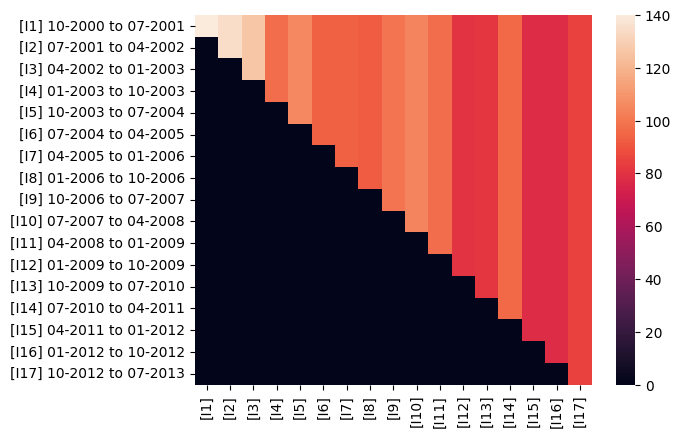

In [17]:
draw_heatmap(allchi2[0].pivot(columns='test_interval', index='train_interval', values='num_of_h0').fillna(0))

The conclusion is that there is a difference between the first years of the dataset (until 2003) and the last years (before 2003). Furthermore, as expected, there are more similarities in the diagonal, which represent consecutive intervals.

We can look at one of the attributes in detail to see how can these results be interpreted. For instance, let's have a look to Resource 825

In [18]:
tcs = TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100)
resource825_sum, resource825_detail = compute_all_chi2(X.loc[:,['Resource_825.0']], tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column], strategy = current_strategy),verbose=True)

DatetimeIndex(['2000-01-03 01:00:00+00:00', '2000-10-03 01:00:00+00:00',
               '2001-07-03 01:00:00+00:00', '2002-04-03 01:00:00+00:00',
               '2003-01-03 01:00:00+00:00', '2003-10-03 01:00:00+00:00',
               '2004-07-03 01:00:00+00:00', '2005-04-03 01:00:00+00:00',
               '2006-01-03 01:00:00+00:00', '2006-10-03 01:00:00+00:00',
               '2007-07-03 01:00:00+00:00', '2008-04-03 01:00:00+00:00',
               '2009-01-03 01:00:00+00:00', '2009-10-03 01:00:00+00:00',
               '2010-07-03 01:00:00+00:00', '2011-04-03 01:00:00+00:00',
               '2012-01-03 01:00:00+00:00', '2012-10-03 01:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='<DateOffset: months=9>')
Split no.: 1 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"(2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",29333,136,78,132,189,36,18
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0,0


4.551727549064172e-51
Split no.: 2 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7
i,,,,,,,,
"(2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",32297,154,246,195,186,35,19,1
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0


8.469272274476101e-62
Split no.: 3 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",28339,182,182,134,81,16,11,1,1,1
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0,0,0


5.976782274961494e-40
Split no.: 4 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,8,9
i,,,,,,,,,
"(2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19932,0,1,2,19,5,11,1,1
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0,0


1.975920815365298e-29
Split no.: 5 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,6
i,,,,,,
"(2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17780,0,0,0,0,2
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0


8.088323126723793e-24
Split no.: 6 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32656,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


7.734289064772959e-45
Split no.: 7 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


2.49540686100864e-44
Split no.: 8 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


1.5954476516652062e-44
Split no.: 9 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


6.689033988391903e-40
Split no.: 10 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


2.7263476915257918e-37
Split no.: 11 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


2.682898748795967e-37
Split no.: 12 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 13 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 14 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 15 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 16 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 17 
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 18 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7
i,,,,,,,,
"(2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",32297,154,246,195,186,35,19,1
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0


8.469272274476101e-62
Split no.: 19 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",28339,182,182,134,81,16,11,1,1,1
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0,0,0


5.976782274961494e-40
Split no.: 20 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,8,9
i,,,,,,,,,
"(2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19932,0,1,2,19,5,11,1,1
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0,0


1.975920815365298e-29
Split no.: 21 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,6
i,,,,,,
"(2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17780,0,0,0,0,2
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2,0


8.088323126723793e-24
Split no.: 22 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32656,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2


7.734289064772959e-45
Split no.: 23 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2


2.49540686100864e-44
Split no.: 24 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2


1.5954476516652062e-44
Split no.: 25 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2


6.689033988391903e-40
Split no.: 26 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2


2.7263476915257918e-37
Split no.: 27 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2


2.682898748795967e-37
Split no.: 28 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 29 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 30 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 31 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 32 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 33 
[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 34 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"(2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",28339,182,182,134,81,16,11,1,1,1
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0,0,0


5.976782274961494e-40
Split no.: 35 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,8,9
i,,,,,,,,,
"(2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19932,0,1,2,19,5,11,1,1
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0,0


1.975920815365298e-29
Split no.: 36 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,6
i,,,,,,
"(2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17780,0,0,0,0,2
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2,0


8.088323126723793e-24
Split no.: 37 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32656,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2


7.734289064772959e-45
Split no.: 38 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2


2.49540686100864e-44
Split no.: 39 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2


1.5954476516652062e-44
Split no.: 40 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2


6.689033988391903e-40
Split no.: 41 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2


2.7263476915257918e-37
Split no.: 42 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2


2.682898748795967e-37
Split no.: 43 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 44 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 45 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 46 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 47 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 48 
[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 49 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,8,9
i,,,,,,,,,
"(2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19932,0,1,2,19,5,11,1,1
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0,0


1.975920815365298e-29
Split no.: 50 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,6
i,,,,,,
"(2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17780,0,0,0,0,2
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2,0


8.088323126723793e-24
Split no.: 51 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32656,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2


7.734289064772959e-45
Split no.: 52 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2


2.49540686100864e-44
Split no.: 53 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2


1.5954476516652062e-44
Split no.: 54 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2


6.689033988391903e-40
Split no.: 55 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2


2.7263476915257918e-37
Split no.: 56 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2


2.682898748795967e-37
Split no.: 57 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 58 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 59 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 60 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 61 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 62 
[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 63 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,6
i,,,,,,
"(2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17780,0,0,0,0,2
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2,0


8.088323126723793e-24
Split no.: 64 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32656,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2


7.734289064772959e-45
Split no.: 65 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2


2.49540686100864e-44
Split no.: 66 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2


1.5954476516652062e-44
Split no.: 67 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2


6.689033988391903e-40
Split no.: 68 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2


2.7263476915257918e-37
Split no.: 69 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2


2.682898748795967e-37
Split no.: 70 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 71 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 72 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 73 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 74 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 75 
[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 76 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32656,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",19898,63,63,2,2


7.734289064772959e-45
Split no.: 77 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",19898,63,63,2,2


2.49540686100864e-44
Split no.: 78 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",19898,63,63,2,2


1.5954476516652062e-44
Split no.: 79 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",19898,63,63,2,2


6.689033988391903e-40
Split no.: 80 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",19898,63,63,2,2


2.7263476915257918e-37
Split no.: 81 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",19898,63,63,2,2


2.682898748795967e-37
Split no.: 82 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 83 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 84 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 85 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 86 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 87 
[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 88 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32292,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",19898,63,63,2,2


2.49540686100864e-44
Split no.: 89 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",19898,63,63,2,2


1.5954476516652062e-44
Split no.: 90 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",19898,63,63,2,2


6.689033988391903e-40
Split no.: 91 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",19898,63,63,2,2


2.7263476915257918e-37
Split no.: 92 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",19898,63,63,2,2


2.682898748795967e-37
Split no.: 93 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 94 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 95 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 96 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 97 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 98 
[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 99 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32431,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",19898,63,63,2,2


1.5954476516652062e-44
Split no.: 100 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",19898,63,63,2,2


6.689033988391903e-40
Split no.: 101 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",19898,63,63,2,2


2.7263476915257918e-37
Split no.: 102 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",19898,63,63,2,2


2.682898748795967e-37
Split no.: 103 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 104 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 105 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 106 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 107 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 108 
[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 109 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29122,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",19898,63,63,2,2


6.689033988391903e-40
Split no.: 110 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",19898,63,63,2,2


2.7263476915257918e-37
Split no.: 111 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",19898,63,63,2,2


2.682898748795967e-37
Split no.: 112 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 113 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 114 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 115 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 116 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 117 
[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 118 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27252,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",19898,63,63,2,2


2.7263476915257918e-37
Split no.: 119 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",19898,63,63,2,2


2.682898748795967e-37
Split no.: 120 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 121 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 122 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 123 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 124 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 125 
[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 126 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27257,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",19898,63,63,2,2


2.682898748795967e-37
Split no.: 127 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 128 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 129 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 130 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 131 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 132 
[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 133 
[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] (2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29649,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",19898,63,63,2,2


1.2287696827937325e-40
Split no.: 134 
[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 135 
[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 136 
[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 137 
[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 138 
[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 139 
[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] (2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19623,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",19898,63,63,2,2


1.155932337271229e-26
Split no.: 140 
[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 141 
[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 142 
[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 143 
[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 144 
[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00] (2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18916,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19898,63,63,2,2


1.1103434715803358e-25
Split no.: 145 
[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 146 
[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 147 
[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 148 
[2000-01-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00] (2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28568,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",19898,63,63,2,2


3.97033516044138e-39
Split no.: 149 
[2000-01-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 150 
[2000-01-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 151 
[2000-01-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00] (2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12284,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",19898,63,63,2,2


1.694506288320092e-16
Split no.: 152 
[2000-01-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06
Split no.: 153 
[2000-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00] (2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"(2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4908,0,0,0,0
"[2000-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",19898,63,63,2,2


1.8912974771311009e-06


/var/folders/gn/y9_k855j2h393t38kf2gfvwc0000gn/T/ipykernel_82209/3502969517.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(resource825_sum.pivot(index='train_interval', columns='test_interval', values='num_of_h0').fillna(-1))


<Axes: xlabel='test_interval', ylabel='train_interval'>

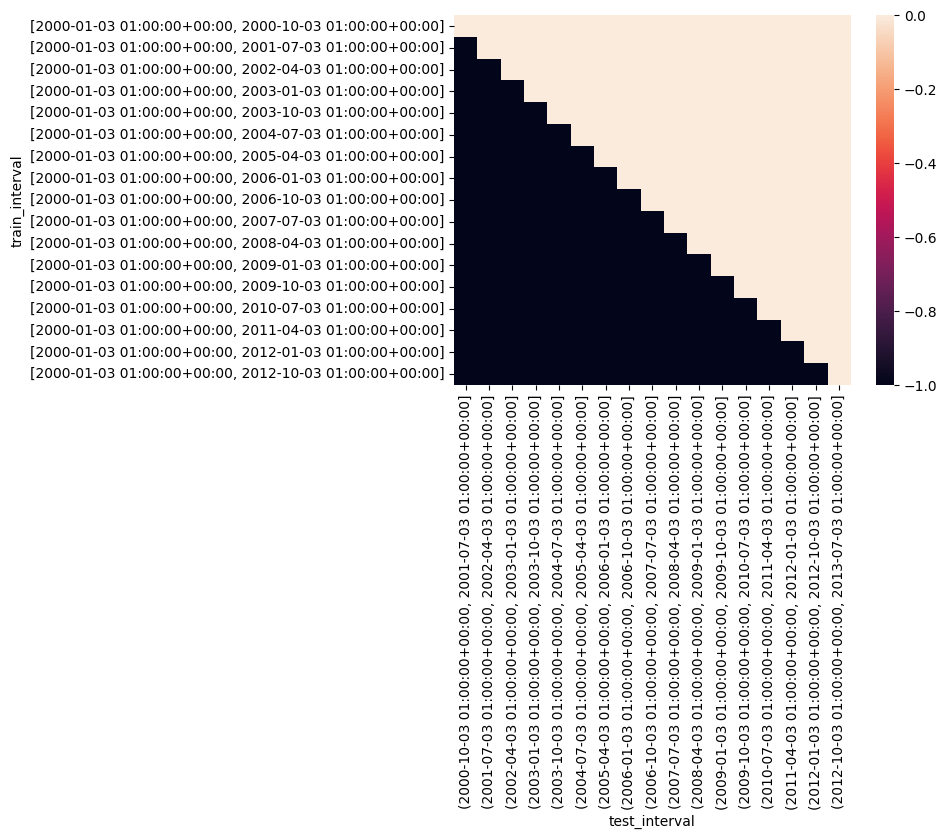

In [19]:
sns.heatmap(resource825_sum.pivot(index='train_interval', columns='test_interval', values='num_of_h0').fillna(-1))

The conclusion is that there is no difference in the dataset since 2004. If we look into the details, we see that this resource stop appearing in the process in 2004. Actually, this coincides with the gap that we detected in the process in that year.

# RQ2: Does time have an influence on the quality of the models?
To answer this question, we are going to analyse the evolution of model performance using the first two strategies (new models each time and updating a model that includes all information):

In [82]:
from experiments import compare_diag, compute_weights, shape_summary, run_experiment_classifier_old, run_experiment, VotingPretrainedClassifier
from splitters import TimeCaseSplit, NumberCaseSplit, CummulativeStrategy, DriftStrategy, CombineStrategy, SamplingStrategy, NonCummulativeStrategy
from sklearn.ensemble import RandomForestClassifier

current_strategy = CummulativeStrategy()

def launch_experiment(months_size, months_freq, months_test, clf, datasets=range(0,5)):
    tcs = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), 
                        train_freq=pd.DateOffset(months=months_freq), 
                        test_freq=pd.DateOffset(months=months_test), 
                        test_periods=14, 
                        threshold=100)
    # summary_X = [None] * 5
    # summary_X_V = [None] * 5
    # summary_X_F = [None] * 5
    # clf = clf
    # clf = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1)
    # for i in datasets:
    agg_clf = VotingPretrainedClassifier(weights=compute_weights)
    #     summary_X[i]= run_experiment(X[i], ~y[i], splits(i, tcs, CummulativeStrategy()), clf)
    #     summary_X_F[i] = run_experiment(X[i], ~y[i], splits(i, tcs, NonCummulativeStrategy(train_size=pd.DateOffset(months=months_size))), clf)
    #     summary_X_V[i] = run_experiment(X[i], ~y[i], splits(i, tcs, NonCummulativeStrategy(train_size=pd.DateOffset(months=months_size))), clf, aggregate_clf=agg_clf, verbose=True)
    splits_x = tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column], strategy=CummulativeStrategy())
    splits_x_f = tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column], NonCummulativeStrategy(train_size=pd.DateOffset(months=months_size)))
    splits_x_v = tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column], NonCummulativeStrategy(train_size=pd.DateOffset(months=months_size)))
    summary_X= run_experiment(X, y, splits_x, clf, summary_class='regular')
    summary_X_F = run_experiment(X, y, splits_x_f, clf, summary_class='regular')
    summary_X_V = run_experiment(X, y,  splits_x_v, clf, aggregate_clf=agg_clf, verbose=True, summary_class='regular')
    
    return summary_X, summary_X_V, summary_X_F


def launch_experiment_rq2(months_size, months_freq, months_test):
    tcs = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700)
    # tcsV = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=True)
    # tcsF = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=False)
    print('Starting X')
    # summary_X= run_experiment(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    summary_X= run_experiment(X, y, splits=tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column], strategy=current_strategy), clf=clf)
    print('Starting X_F')
    # summary_X_F = run_experiment(X, y, tcsF.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_V')
    # summary_X_V = run_experiment(X, y, tcsV.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
        
    return summary_X, summary_X_F, summary_X_V


def launch_experiment_rq2_orig(months_size, months_freq, months_test):
    tcs = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=True)
    tcsV = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=True)
    tcsF = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=False)
    print('Starting X')
    summary_X= run_experiment(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_F')
    summary_X_F = run_experiment(X, y, tcsF.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_V')
    summary_X_V = run_experiment(X, y, tcsV.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
        
    return summary_X, summary_X_F, summary_X_V

def launch_experiment_rolling(size, freq, window, steps, datasets=range(0,5)):
    tcs = NumberCaseSplit(train_size=size, train_freq=freq, threshold=500,sliding=True)
    tcsF = NumberCaseSplit(train_size=size, train_freq=freq, threshold=500,sliding=False)
    print('Starting X')
    summary_X= run_experiment(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]),window, steps, summary_class='regular')
    print('Starting X_F')
    summary_X_F = run_experiment(X, y, tcsF.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), window, steps,summary_class='regular')
    print('Starting X_V')
    
    return summary_X, summary_X_F, summary_X_V


def make_nonzero(array):
    min_positive_value = np.nextafter(0, 1)  
    threshold = 1.71e-321
    array = np.transpose(array)
    array[array < threshold] += threshold
    return np.transpose(array)


def launch_experiment_number(size, freq, test, datasets=range(0,5)):
    tcs = NumberCaseSplit(train_size=size, train_step=freq, test_freq=test, test_periods=20,threshold=500)  #sliding=True)
    tcsV = NumberCaseSplit(train_size=size, train_step=freq, test_freq=test, test_periods=20, threshold=500) # sliding=True)
    tcsF = NumberCaseSplit(train_size=size, train_step=freq, test_freq=test, test_periods=20, threshold=500) # sliding=False)
    tcsS = NumberCaseSplit(train_size=size, train_step=freq, test_freq=test, test_periods=20, threshold=500) # sliding=False, sampling=True)
    
    tcsS_splits = tcsS.split(X,y,log.df[log.id_column], log.df[log.timestamp_column], strategy=NonCummulativeStrategy(train_size=size))
    tcs_splits = tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column], strategy= NonCummulativeStrategy(train_size=size))
    tcsF_splits = tcsF.split(X,y,log.df[log.id_column], log.df[log.timestamp_column], strategy= CummulativeStrategy())
    weights = compute_weights(length=freq)
    weights = make_nonzero(weights)
    tcsV_splits = tcsV.split(X,y,log.df[log.id_column], log.df[log.timestamp_column], strategy= SamplingStrategy(train_size=size, weights=weights))
    
    clf = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1)
    agg_clf = VotingPretrainedClassifier(weights=compute_weights)
    
    print('Starting X_V')
    summary_X_V= run_experiment(X, y, tcsV_splits, clf, summary_class='regular')
    print('Starting X_S')
    summary_X_S = run_experiment(X, y, tcsS_splits, clf, summary_class='regular')
    print('Starting X')
    summary_X = run_experiment(X, y, tcs_splits, clf, summary_class='regular')
    print('Starting X_F')
    summary_X_F =run_experiment(X, y, tcsF_splits, clf, summary_class='regular')

    
    return summary_X, summary_X_F, summary_X_V, summary_X_S
        

In [21]:
clf = RandomForestClassifier(random_state=0,n_estimators=100,n_jobs=-1)

summary_999 = launch_experiment(9,9,9, clf = clf)

DatetimeIndex(['2000-01-03 01:00:00+00:00', '2000-10-03 01:00:00+00:00',
               '2001-07-03 01:00:00+00:00', '2002-04-03 01:00:00+00:00',
               '2003-01-03 01:00:00+00:00', '2003-10-03 01:00:00+00:00',
               '2004-07-03 01:00:00+00:00', '2005-04-03 01:00:00+00:00',
               '2006-01-03 01:00:00+00:00', '2006-10-03 01:00:00+00:00',
               '2007-07-03 01:00:00+00:00', '2008-04-03 01:00:00+00:00',
               '2009-01-03 01:00:00+00:00', '2009-10-03 01:00:00+00:00',
               '2010-07-03 01:00:00+00:00', '2011-04-03 01:00:00+00:00',
               '2012-01-03 01:00:00+00:00', '2012-10-03 01:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='<DateOffset: months=9>')
DatetimeIndex(['2000-01-03 01:00:00+00:00', '2000-10-03 01:00:00+00:00',
               '2001-07-03 01:00:00+00:00', '2002-04-03 01:00:00+00:00',
               '2003-01-03 01:00:00+00:00', '2003-10-03 01:00:00+00:00',
               '2004-07-03 01:00:00+00:00', '2005

/var/folders/gn/y9_k855j2h393t38kf2gfvwc0000gn/T/ipykernel_82209/1147182583.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  draw_heatmap(shape_summary(summary_999[1]).fillna(0).xs('f1-score',axis=1,drop_level=True),vmax=1)


<Axes: >

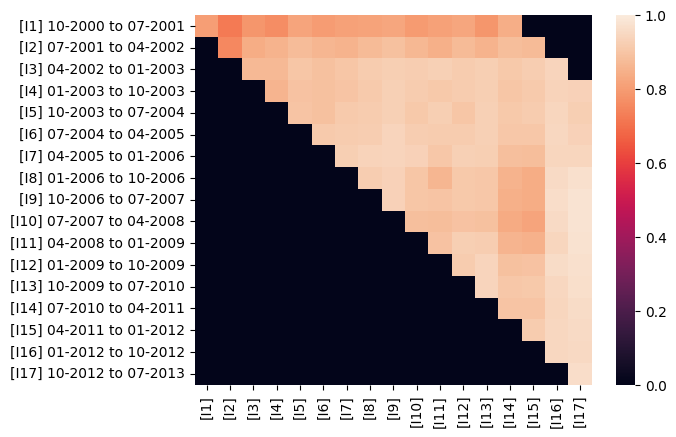

In [23]:
from experiments import shape_summary
draw_heatmap(shape_summary(summary_999[1]).fillna(0).xs('f1-score',axis=1,drop_level=True),vmax=1)

/var/folders/gn/y9_k855j2h393t38kf2gfvwc0000gn/T/ipykernel_82209/827082677.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  draw_heatmap(shape_summary(summary_999[0]).fillna(0).xs('f1-score',axis=1,drop_level=True),vmax=1)


<Axes: >

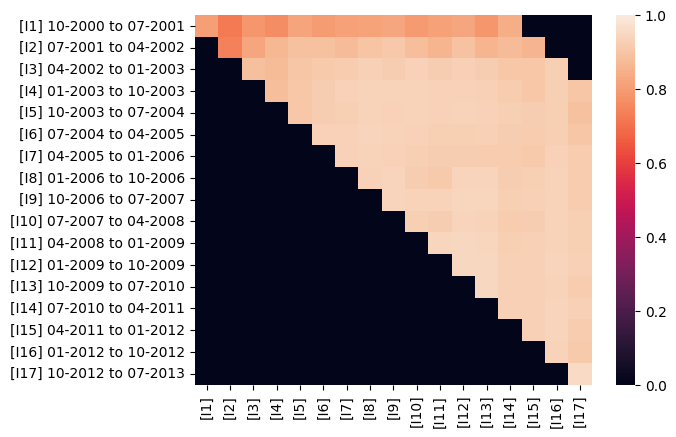

In [24]:
draw_heatmap(shape_summary(summary_999[0]).fillna(0).xs('f1-score',axis=1,drop_level=True),vmax=1)

In [65]:
# TODO check what this should show 
# sns.heatmap(shape_summary(summary_9_F_r).fillna(0))

In [83]:
summary_n, summary_n_F, summary_n_V, summary_n_S = launch_experiment_number(8641,4320,4320)

Starting X_V
Starting X_S
Starting X
Starting X_F


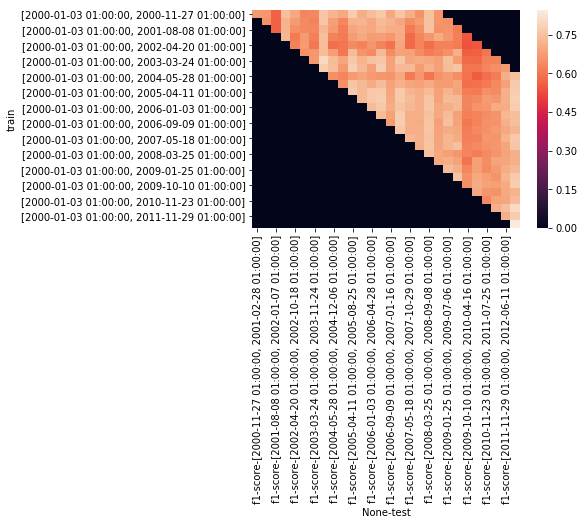

In [ ]:
sns.heatmap(shape_summary(summary_n_F).fillna(0))

# RQ3: How does the different update strategies compare against each other?

Finally, we compute execute the experiment for all types of strategies. The final value is the mean of the F-Scores in the diagonal of the matrix obtained.

In [ ]:
summary_n_all = [summary_n, summary_n_F, summary_n_V, summary_n_S]

In [ ]:
def extract_values(summary, step = 0):
    mask = summary[0].sort_values(['train','test']).groupby('train').cumcount() <= step
    return pd.concat([summary[i][mask]['f1-score'] for i in range(len(summary))],axis=1)

In [ ]:
summary_n_fscore = extract_values(summary_n_all)
summary_n_fscore.columns = ['X','F','V','S']


In [ ]:
summary_n_fscore.mean()

X    0.694372
F    0.703657
V    0.714230
S    0.705357
dtype: float64

Here, we use the T-test related to check whether there is a significant difference between each column. The result is that only the difference between 'V' and 'X is statistically significant.

In [ ]:
from scipy import stats
[(i,j,stats.ttest_rel(summary_n_fscore[i], summary_n_fscore[j])) for ii,i in enumerate(summary_n_fscore.columns) for jj,j in enumerate(summary_n_fscore.columns) if i < j]

[('F',
  'X',
  Ttest_relResult(statistic=1.2527671941138439, pvalue=0.22103241726995335)),
 ('F',
  'V',
  Ttest_relResult(statistic=-1.3650320688729325, pvalue=0.18351044883548195)),
 ('F',
  'S',
  Ttest_relResult(statistic=-0.46362856787053, pvalue=0.6466298815649716)),
 ('V',
  'X',
  Ttest_relResult(statistic=3.1507531132969744, pvalue=0.003957876483001759)),
 ('S',
  'X',
  Ttest_relResult(statistic=1.6928052455530407, pvalue=0.10200215288924347)),
 ('S',
  'V',
  Ttest_relResult(statistic=-1.1216114246414404, pvalue=0.27190415125728346))]